# VLF data overview
## Vojtěch Laitl 2016
### Ionozor Measuring Network - VLF monitors data anylysis and graph processing

This is an iPython Juypter notebook made for SID monitors and their data overview. The computations are covered by a simplified ionospheric plasma physics model and based on iPython 2.X modules. The script does loads the primary data saved in the FITS format, runs the data processing tools and saves the results into the folders defined.

In [2]:
import numpy as np
import scipy
import astropy.io 
from astropy.io import fits
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
from scipy.integrate import quad
import cmath
import scipy.interpolate as interpol
from mpl_toolkits.mplot3d import Axes3D
import os
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

First of all, the essential modules are imported.

In [7]:
output_slider_variable = widgets.Text()
def f(url):
    output_slider_variable.value = str(url)

interact(f,url='http://space.astro.cz/ionozor/VLF/valmez/VALMEZ_VLF_R0/snapshots/2017/04/02/18/20170402183540099_VALMEZ_VLF_R0_snap.fits')

<function __main__.f>

Next, we define the source URL. For the SID data, you ought to use some of our observatories accessible at the website of http://space.astro.cz/ionozor/VLF/. Then, the only thing you need to set the requested URL is to run the cell above and type it into the `url` box appeared, so that you replace the current value by the appropriate URL string pointing to selected data snapshots.

In [8]:
data_file = download_file(output_slider_variable.value, cache=True )
data_list = fits.open(data_file)
data_list.info()
data = data_list[1].data
data_list.close

Filename: /home/kaklik/.astropy/cache/download/b34a4509d0028c3ef56bb8f633be0157
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   ()              
1                CompImageHDU     24   (4438, 586)   float32   


<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f41ef423ef0>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x7f41efccc6a0>]>

Above, the data have been downloaded and saved into an appropriate numpy 2D array object. If successful, you will be informed that the HDUlist of the `FITS` file characterised by the number, name type, cards, dimensions and format has been closed.

In [9]:
epsilon = 8.8542e-12
e = 1.602e-19
k_B = 1.38e-23
gamma = 0.001
R_inf = 3.2899e15
c = 3e8
b = 2.898e-3
h = 6.626e-34
m_el = 9.109e-31
R = 8.314
N_A = 6.022e23
lambda_De = 3.10399215e-05
I0 = -26.74
R = 1.496e11
i = scipy.sqrt(-1)
nu = 18000+(16+2/3)*np.arange(0,len(data))
t = np.arange(0,len(data[0]))*300/len(data[0])

Here, all of the constants needed for the computation are defined and the time and frequency shapes are set from the axes given.

In [10]:
os.mkdir('ionosphere')
os.mkdir('meteors')
os.mkdir('sun')
os.mkdir('molecules')

For the oncoming saving of our results, we have created the appropriate subfolders, `ionosphere`, `meteors`, `sun` and `molecules` are created using the os module. If you ever run the whole script and get a FileExistsError near this command, it means you must have used the tool before, so that the subfolders cannot be re-created. Then, you have to copy the previous data and delete the original subfolders.

In [11]:
L = -data*1000
n0 = -1/4*L**-4
n0[np.isinf(n0)]=0
E_k = -36*np.pi**-2*epsilon**-4/3*n0*e**4
T = -E_k/k_B
d_lambda_De = np.sqrt(np.abs((epsilon*k_B*T)/(n0*e**2)))
p = np.diff(E_k,0)
nu_delta = p*c/h
omega = (nu+nu_delta.reshape((len(nu_delta[0]),len(nu)))).reshape((len(nu_delta),len(nu_delta[0])))
n = (omega**2*m_el*epsilon)/e**2
T_el = np.abs(T*n)
T_el = T_el+190.05
T_el[T_el>=10**4]=0
n[n>9.99999*10**8]=0
n = (n.reshape((len(nu_delta[0]),len(nu)))+(nu**2*m_el*epsilon)/e**2).reshape((len(nu_delta),len(nu_delta[0])))
dn = np.diff(n,0)
N_D = 4/3*np.pi*lambda_De*n
N = (n.reshape((len(nu_delta[0]),len(nu)))-(nu**2*m_el*epsilon)/e**2).reshape((len(nu_delta),len(nu_delta[0])))
Bl = 1+(0.01*L)
mD = 10e-10
h0 = np.pi*Bl/(2+2*mD)
h0_t = (10*h0)**2/10
f_n = dn*Bl/(N*(1-mD))
f_n2 = f_n**2
f_ln = np.log(1/2*f_n-((f_n2**2 - 4)**1/2))
h_t = np.abs((Bl*f_ln + 2*np.pi*i)/(1-mD))
H = np.nan_to_num(10*(h0_t + h_t)/3)
H[H<59.999]=0
Is = np.exp(L/10)
fce = Is*R**2/I0
alpha = scipy.arccos(fce)
s = H*np.tan(np.abs(alpha))
W_k = (3/2*k_B*T_el)/e
p_el = np.diff(W_k,0)
W_p = (2*W_k)/(9*N_D**2/3)
v = (3*k_B*T_el/(n*m_el))**1/2*lambda_De
ac = np.diff(v,0)
s_e = (2*k_B*T_el**3/(n*m_el))**1/2*lambda_De**3
A0 = ((dn+n)/n)/(1000*N_A)
B0 = R*T
E_a = np.abs(-np.log(A0**B0))/e + h*1.21567e-7/e
E_a[np.isinf(E_a)]=0
U_i = E_a*e
i_1 = np.nan_to_num((2.4e21*T_el**3/2*np.exp((-U_i*lambda_De)/(3*k_B*T_el)))/(N_A*n))+n/N_A
i_2 = np.nan_to_num(((2.4*10e21*T_el**3/2*np.exp((-U_i*lambda_De)/(n*N_D**3*k_B*T_el))**3/4)**0.8584)/(N_A*n))
i_avrg = (i_1+i_2)/2
p = h0*(mD-1)
p1 = H*(1-mD) + np.pi
n_el = 10*(np.exp((2*N_D/1000*(p1-p) + Bl)/Bl) + 4*H)
n_el1 = n_el/10e6
T_e = 3**2/3*e**2*n_el**1/3*N_D**2/3/(epsilon*k_B*(4*np.pi)**2/3)*lambda_De**1.2
n_e = 10*(np.exp((2*N_D/1000000*(p1-p) + Bl)/Bl) + 4*H)
n_e1 = n_e/10e6
T_EL = 3**2/3*e**2*n_e**1/3*N_D**2/3/(epsilon*k_B*(4*np.pi)**2/3)*lambda_De**1.2
lambda_M = (h*c*lambda_De**(N_D/100))/(k_B*T_e)
lambda_M[np.isinf(lambda_M)]=0
lambda_M = np.nan_to_num(lambda_M)
lambda_S = (h*c*lambda_De**(N_D/100))/(k_B*T_EL)
lambda_S[lambda_S<10e-18]=0
lambda_S[lambda_S>10e5]=0
f_nh = (-2*H*(mD-1) + h0_t*(-mD) + h0_t + np.pi)/(1+(0.01*L))
f_exp = np.exp(f_nh)
f_T = (-2**4/3*(mD-1)*N*(1-mD)*np.log10(np.e)*f_exp)/(3*(1+(0.01*L))**2*N*(1-mD)*f_exp)
f_T[np.isnan(f_T)]=1
dT = 3**2/3*e**2*N_D**2/3/(epsilon*k_B*(4*np.pi)**2/3)*lambda_De**6/5*f_T
dT[np.isinf(dT)]=0
dTe = np.diff(T_e,0)
Z = -1/dTe*dT
Z[np.isinf(Z)]=0
Z = np.nan_to_num(Z)
f1 = n_el*E_a*e/Z
f1[np.isinf(f1)]=0
f1 = np.nan_to_num(f1)
f2 = k_B*T_e
f2[np.isinf(f2)]=0
f2 = np.nan_to_num(f2)
f_I = f1*f2*np.exp(-T_el/T_e)
f_I[np.isinf(f_I)]=0
f_I = np.nan_to_num(f_I)
I = np.abs(scipy.log(f_I))
I[np.isinf(I)]=0
I = np.nan_to_num(I)
dTS = 10*np.abs(np.log(b/lambda_S))
dTS[np.isinf(dTS)]=0
TS = np.exp(dTS/10)
nS = (16*epsilon**3*k_B**3*np.pi**2*lambda_De**1.5*TS)/(9*e**6*N_D**2)
dTS = np.diff(TS,0)
dTS[np.isinf(dTS)]=0
Z = -1/dTS*dT
f1 = n_el*E_a*e/Z
f1[np.isinf(f1)]=0
f1 = np.nan_to_num(f1)
f2 = k_B*TS
f2[np.isinf(f2)]=0
f2 = np.nan_to_num(f2)
f_I = f1*f2*np.exp(-T_el/TS)
IS = np.abs(scipy.log(f_I))
IS[np.isinf(IS)]=0
IS = np.nan_to_num(IS)
T = 10*np.abs(np.log(b/lambda_M))
T[np.isinf(T)]=0
T = np.nan_to_num(T)
dTe1 = np.diff(T,0)
lambda_m = b/T
lambda_m[np.isinf(lambda_m)]=0
dT = np.abs(10*(np.log(T)))
N = (16*epsilon**3*k_B**3*np.pi**2*lambda_De**1.5*np.exp(dT/(0.1*N_D)))/(9*e**6*N_D**2)
N[np.isinf(N)]=0
N = np.nan_to_num(N)
lambdas = b/TS
E = E_a + h*nu_delta/e
s_O2 = (2*9.339e012-9.312e007)/10e12
s_N2 = (2*3.4711e+012-9.312e+007)/10e12
s_N2O = (3*4.0732e012 - 9.312e+007)/10e12
s_NO = (2*6.1824e+012 - 9.312e+007)/10e12
s_CO2 = (2*6.9482e012 - 9.312e007)/10e12
s_OH = (9.7e012-9.312e007)/10e12
lambdap = (h*c)/(E_a*e*lambda_De**3/n*N_D)*10e4
lambdap[np.isinf(lambdap)]=0
sl_O2 = np.abs(lambdap-s_O2)
sl_N2 = np.abs(lambdap-s_N2)
sl_N2O = np.abs(lambdap-s_N2O)
sl_NO = np.abs(lambdap-s_NO)
sl_CO2 = np.abs(lambdap-s_CO2)
sl_OH = np.abs(lambdap-s_OH)
E_O2 = h*c/(sl_O2)/e*n**(3.5*N_D/100)
E_N2 = h*c/(sl_N2)/e*n**(3.5*N_D/100)
E_N2O = h*c/(sl_N2O)/e*n**(3.5*N_D/100)
E_NO = h*c/(sl_NO)/e*n**(3.5*N_D/100)
E_CO2 = h*c/(sl_CO2)/e*n**(3.5*N_D/100)
E_OH = h*c/(sl_OH)/e*n**(3.5*N_D/100)
C_e = gamma*n*T_el
Q = C_e*m_el*T/e
dQ = np.diff(Q,0)
S = dQ/T_el
tau = np.nan_to_num((np.insert(np.diff(t),0,0)+t)/t)
F = E_a*e/(tau*n)
F_V = F/(lambda_De*e)
E_N = E_N2/E
N_N = E_N2/E_N
E_O = E_O2/E
N_O = E_O2/E_O
e_N2O = E_N2O/E
N_N2O = E_N2O/e_N2O
e_NO = E_NO/E
N_NO = E_NO/e_NO
e_CO2 = E_CO2/E
N_CO2 = E_CO2/e_CO2
N_ne = N_O+N_N+N_N2O+N_NO+N_CO2
lambda_N = h*c/(E_N*e)
lambda_O = h*c/(E_O*e)
lambda_OH = h*c/(E_OH*e)
ds = np.diff(1000*s,0)
dN = np.diff(N,0)
n_H = np.nan_to_num((10**12*dn)**(1/3))
N_H = (10**12*(-dN))**1/3
r_min = 10*ds/n_H
r_min[np.isinf(r_min)]=0
r_min = np.nan_to_num(r_min)
r_max = (1/len(s)*(np.nan_to_num(2/3*r_min**2+1/3*(N_H/ds)**2))**(1/2))/10**2
r_max[r_max>9.999999e07]=0
r_max = np.nan_to_num(r_max)
r_H = 1000*(len(s)**2*ds**2*n_H+10**4*len(s)*ds**2-len(s)*n_H**2-2*10**8*n_H)/(len(s)**2*(ds*n_H**2-ds*n_H*N_H))
r_H[np.isinf(r_H)]=0
r_H = np.nan_to_num(r_H)
n_mean = np.mean(n,axis=1)
T_mean = np.mean(T_el,axis=1)
H_mean = np.mean(H,axis=1)*3
s_mean = np.mean(s,axis=1)*3
data_mean = np.mean(data,axis=1)
L_mean = np.mean(L,axis=1)
f = interpol.interp1d(nu,H_mean,kind='quadratic')
F = f(nu)
g = interpol.interp2d(nu,data_mean,L_mean)
G = g(nu,data_mean)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.5/dist-packages/ipykernel_launch

By the time all of the essential parameters and functions are set, the data processing tools itself can be run. It covers the basic ionospheric plasma physics and plasma chemistry equations involved by a simplified ionospheric model, which covers both ionospheric plasma parameters and the phenomenon of ionospheric response. Such a combination allows us to reach exact results wihtin the indirect detection of a solar or meteoric impact.

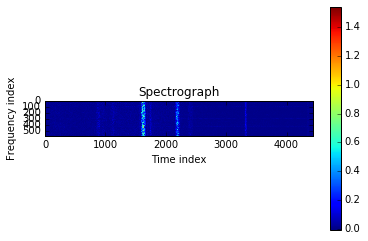

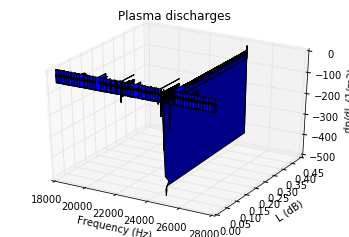

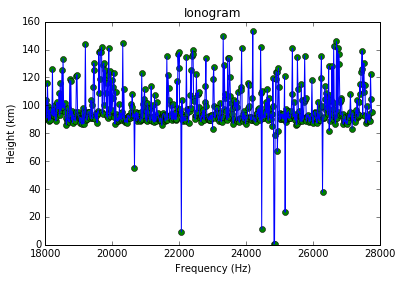

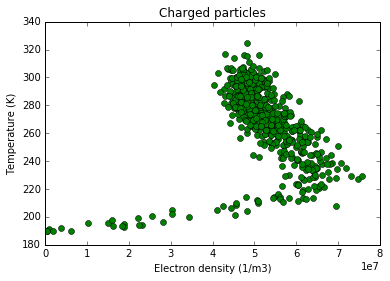

In [12]:
fig1 = plt.figure()
plt.imshow(data)
plt.colorbar()
plt.title('Spectrograph')
plt.xlabel('Time index')
plt.ylabel('Frequency index')
fig1.savefig('spectrograph.png')
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.plot_surface(nu,data_mean,G)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('L (dB)')
ax.set_zlabel('dn/dL (1/m3)')
ax.set_title('Plasma discharges')
fig2.savefig('plasma_discharges.png')
fig3 = plt.figure()
plt.plot(nu,H_mean,'go'),plt.plot(nu,F)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Height (km)')
plt.title('Ionogram')
fig3.savefig('ionogram.png')
fig4 = plt.figure()
plt.plot(n_mean,T_mean,'go')
plt.xlabel('Electron density (1/m3)')
plt.ylabel('Temperature (K)')
plt.title('Charged particles')
fig4.savefig('charged_particles.png')
fig5 = plt.figure()
plt.plot(H_mean,s_mean,'go')
plt.xlabel('Vertical drift (km)')
plt.ylabel('Horizontal drift (km)')
plt.title('Ionospheric drift')
fig5.savefig('ionospheric_drift.png') 	
plt.close()

After the data are processed, some example graphs are drawn and saved into your working directory. Having a look at them, one can make a brief description of the ionospheric behaviour during the investigated time period.
As the final result, the figures drawn are shown using matplotlib.
#### Spectrograph
    The spectrograph plot shows the measured data themselves. The radio signal intensity level is shown within a 2-D char where the x-axis shows the time index and the y-axis the frequency index of the relative intensity of radio waves monitored.
#### Plasma discharges
    Plasma discharges plot covers the inital step of the mathematical model. The frequency set and the relative intensity measured are compared with each other and interlanded with the basic equation of the plasma physics model 
\begin{equation}
\frac{\partial{n}}{\partial{L}} \approx - \frac{1}{4}L^{-4}
\end{equation}
#### Ionogram
    The next graph is the standard ionogram, a digram which shows the relation between the frequency (electron plasma frequency and thus mean electron density, respectively) and the height where the ionospheric plasma is being located. The ionogram involves both measured daa ad interpolaton.
#### Charged particles
    As the result of plasma parameters modelling, a simple diagram showing the electron density and plasma temperature is given.
#### Ionospheric drift
    The last step of this data processing tool is the diagram which shows the ionospheric plasma distribution involving both vertical distribution and horizontal distribution; they both are able to be reached within the ionogram.

In [ ]:
np.savetxt('time.txt',t)
np.savetxt('frequency.txt',nu)

The time and frequency dimensions are saved into `-ascii` data files, so that the resultant data can be scaled anytime if necessary.

In [ ]:
owd = os.getcwd()
os.chdir('ionosphere')
np.savetxt('plasma_frequency.txt',omega)
np.savetxt('electron_density.txt',n)
np.savetxt('termodynamic_temperature.txt',T_el)
np.savetxt('plasma_parameter.txt',N_D)
np.savetxt('kinetic_energy.txt',W_k)
np.savetxt('potential_energy.txt',W_p)
np.savetxt('height.txt',H)
np.savetxt('horizontal_drift.txt',s)
np.savetxt('mean_velocity.txt',v)
np.savetxt('fluctuation_scope.txt',s_e)
np.savetxt('refraction_angle.txt',alpha)
np.savetxt('heat.txt',Q)
np.savetxt('calorific_capacity.txt',C_e)
np.savetxt('entropy.txt',S)
np.savetxt('x_ray_flux.txt',F)
np.savetxt('x_ray_flux_debye.txt',F_V)
os.chdir(owd)
os.chdir('meteors')
np.savetxt('electron_density.txt',N)
np.savetxt('termodynamic_temperature.txt',T)
np.savetxt('wavelength.txt',lambda_m)
np.savetxt('intensity.txt',I)
np.savetxt('inner_radius.txt',r_min)
np.savetxt('outer_radius.txt',r_max)
np.savetxt('descent_height.txt',r_H)
os.chdir(owd)
os.chdir('sun')
np.savetxt('electron_density.txt',nS)
np.savetxt('termodynamic_temperature.txt',TS)
np.savetxt('wavelength.txt',lambda_S)
np.savetxt('intensity.txt',IS)
os.chdir(owd)
os.chdir('molecules')
np.savetxt('ionization_potential.txt',U_i)
np.savetxt('energy_O2.txt',E_O2)
np.savetxt('energy_O.txt',E_O)
np.savetxt('energy_N2.txt',E_N2)
np.savetxt('energy_N2O.txt',E_N2O)
np.savetxt('energy_NO.txt',E_NO)
np.savetxt('energy_CO2.txt',E_CO2)
np.savetxt('energy_OH.txt',E_OH)
np.savetxt('energy_N.txt',E_N)
np.savetxt('energy_O.txt',E_O)
np.savetxt('wavelength_OH.txt',lambda_OH)
np.savetxt('wavelength_O.txt',lambda_O)
np.savetxt('wavelength_N.txt',lambda_N)
np.savetxt('intensity.txt',I)
os.chdir(owd)

Finally, using the `-ascii` format, the resultant data are saved and separated into the prepared subfolders.
Having run the data processing, we reached some informations about the ionospheric plasma in the D layer, picking up the basic physical parameters of the cold plasma and ionogram characteristics, which both are stored in the `ionosphere` subfolder. Moreover, we have had a look at the behaviour of the cold molecular and ion clouds located in the ionosphere, paying extra attention to the spectral diagnostics. For such results, see the `molecules` subfolder.
Combining the physical model, the calculated paramters of the radio waves reflection phenomena and with the aspects of particle behaviour known, we have implemented the equations used for defining the ionospheric response and reached some of the basic informations about solar and meteoric impacts. Generally, we calculate the spectral parameters and also the electron density and plasma temperature of the impact falling into the ionosphere, see `meteors` and `sun` subfolders. Moreover, within the observation of meteors, we have even reached the description of the electron density distribution in 3D normalized metrical space, see the appropriate resultant data.